# APOL gene expression analysis
Here I analyse the APOL gene expression patterns in ND and T2DM pancreatic cells

In [234]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import * 
import numpy as np
import scanpy as sc
import gseapy

Set scanpy and matplotlib plot settings

In [235]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

figdir = '../figures'
sc.settings.figdir = figdir


scanpy==1.9.3 anndata==0.7.5 umap==0.5.1 numpy==1.23.3 scipy==1.9.2 pandas==1.5.1 scikit-learn==1.1.2 statsmodels==0.12.0 python-igraph==0.9.0 leidenalg==0.8.3 pynndescent==0.5.2


Import the anndata object and load it with Scanpy

In [236]:
# Import anndata object
h5ad = '../3UTRpancreas_apoL_project.h5ad'
adata = sc.read_h5ad(h5ad)

For the paper rename healthy to ND and T2D to T2DM

In [237]:
def rename(group):
    if group == 'T2D':
        groupnew = 'T2DM'
    elif group == 'healthy':
        groupnew = 'ND'
    return groupnew

adata.obs['Group'] = adata.obs['Group'].apply(lambda g: rename(g)) 

Generate a new column containing the cluster and group

In [238]:
adata.obs['cluster-group'] = ['-'.join([i,j]) for i,j in zip(adata.obs['Cluster'], adata.obs['Group'])]

Recolor beta cell clusters (swap  '#c5b0d5' and  '#ff9896')

In [239]:
adata.uns['cluster-group_colors'] = 
['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#17becf',
 '#aec7e8',
 '#ffbb78',
 '#98df8a',
 '#c5b0d5',
 '#ff9896',
 '#c49c94',
 '#f7b6d2']

Make a subset anndata object for each cell type including all cells

In [254]:
adata_dict = {}

for ct in adata.obs['Cluster']:
    adata_dict[ct] = adata[adata.obs['Cluster'] == ct]
    
adata_dict['all_cells'] = adata
    

## Violin plots
Violin plots showing the expression levels of APOL genes in beta cells types for healthy vs T2D

In [215]:
def violin(adata, genes, groupby=group, ylabel='log(normalized expression)', order=order, figsize=4, wspace=0.5, nrows=1, savefile=''):
    #Scanpy violin plot with custom matplotlib parameters
    
    ncols=len(genes)
    rcParams['mathtext.fontset'] = 'custom'
    rcParams['mathtext.bf'] = 'Sans:italic:bold'

    fig, axs = plt.subplots(nrows=nrows,ncols=ncols, figsize=(ncols*figsize+figsize*wspace*(ncols-1),nrows*figsize))

    for i, gene in enumerate(genes):
        sc.pl.violin(adata, gene, groupby=groupby,ylabel=ylabel, 
                     ax=axs[i], size=3, order=order, show=False)
        axs[i].grid(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].set_title(r"$\mathbf{"+gene+"}$") #bold and italic plot title

        axs[i].set_xticks(range(len(order)))
        axs[i].set_xticklabels(order)
        axs[i].set_xlabel('')
        
    fig.savefig(savefile+'.png')

APOL1, APOL2, APOL6 expression in ND beta cells

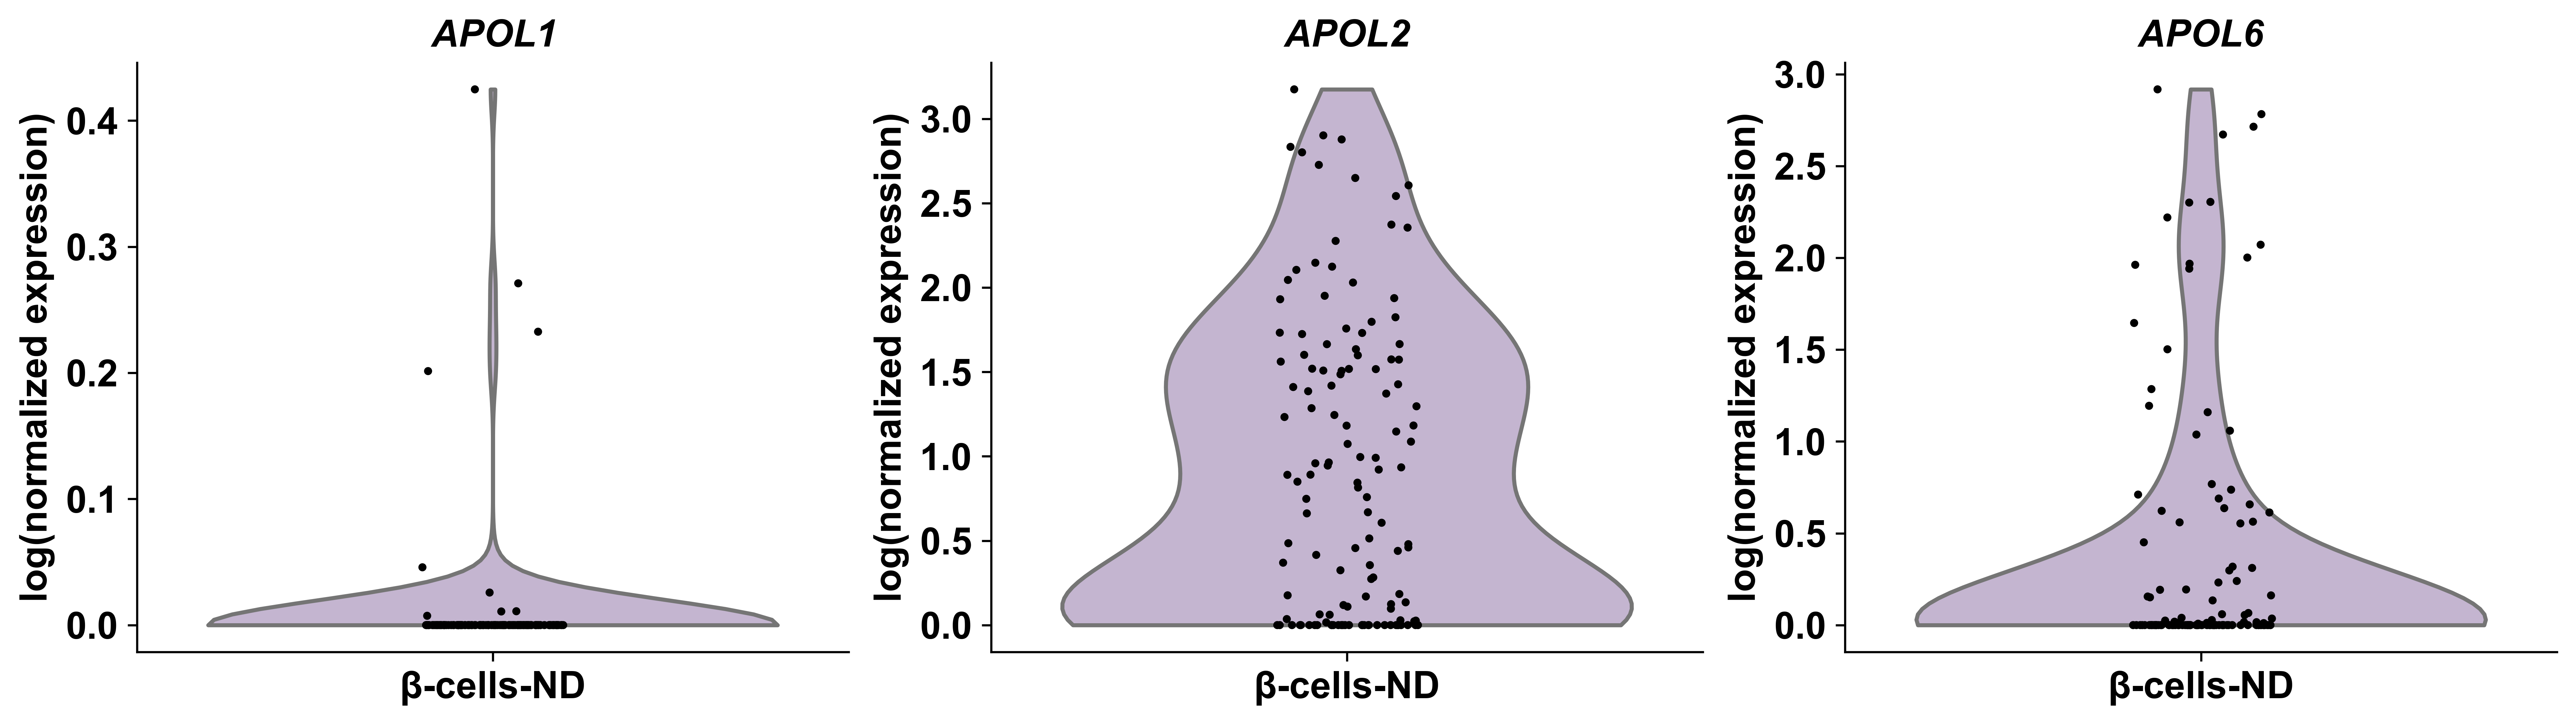

In [216]:
genes = ['APOL1', 'APOL2','APOL6']
group = 'cluster-group'
order = ['β-cells-ND']

violin(adata, genes, groupby=group,  order=order, savefile=str(figdir+ '/violin_APOL126_betaND'))

APOL3, APOL4 expression in ND beta cells

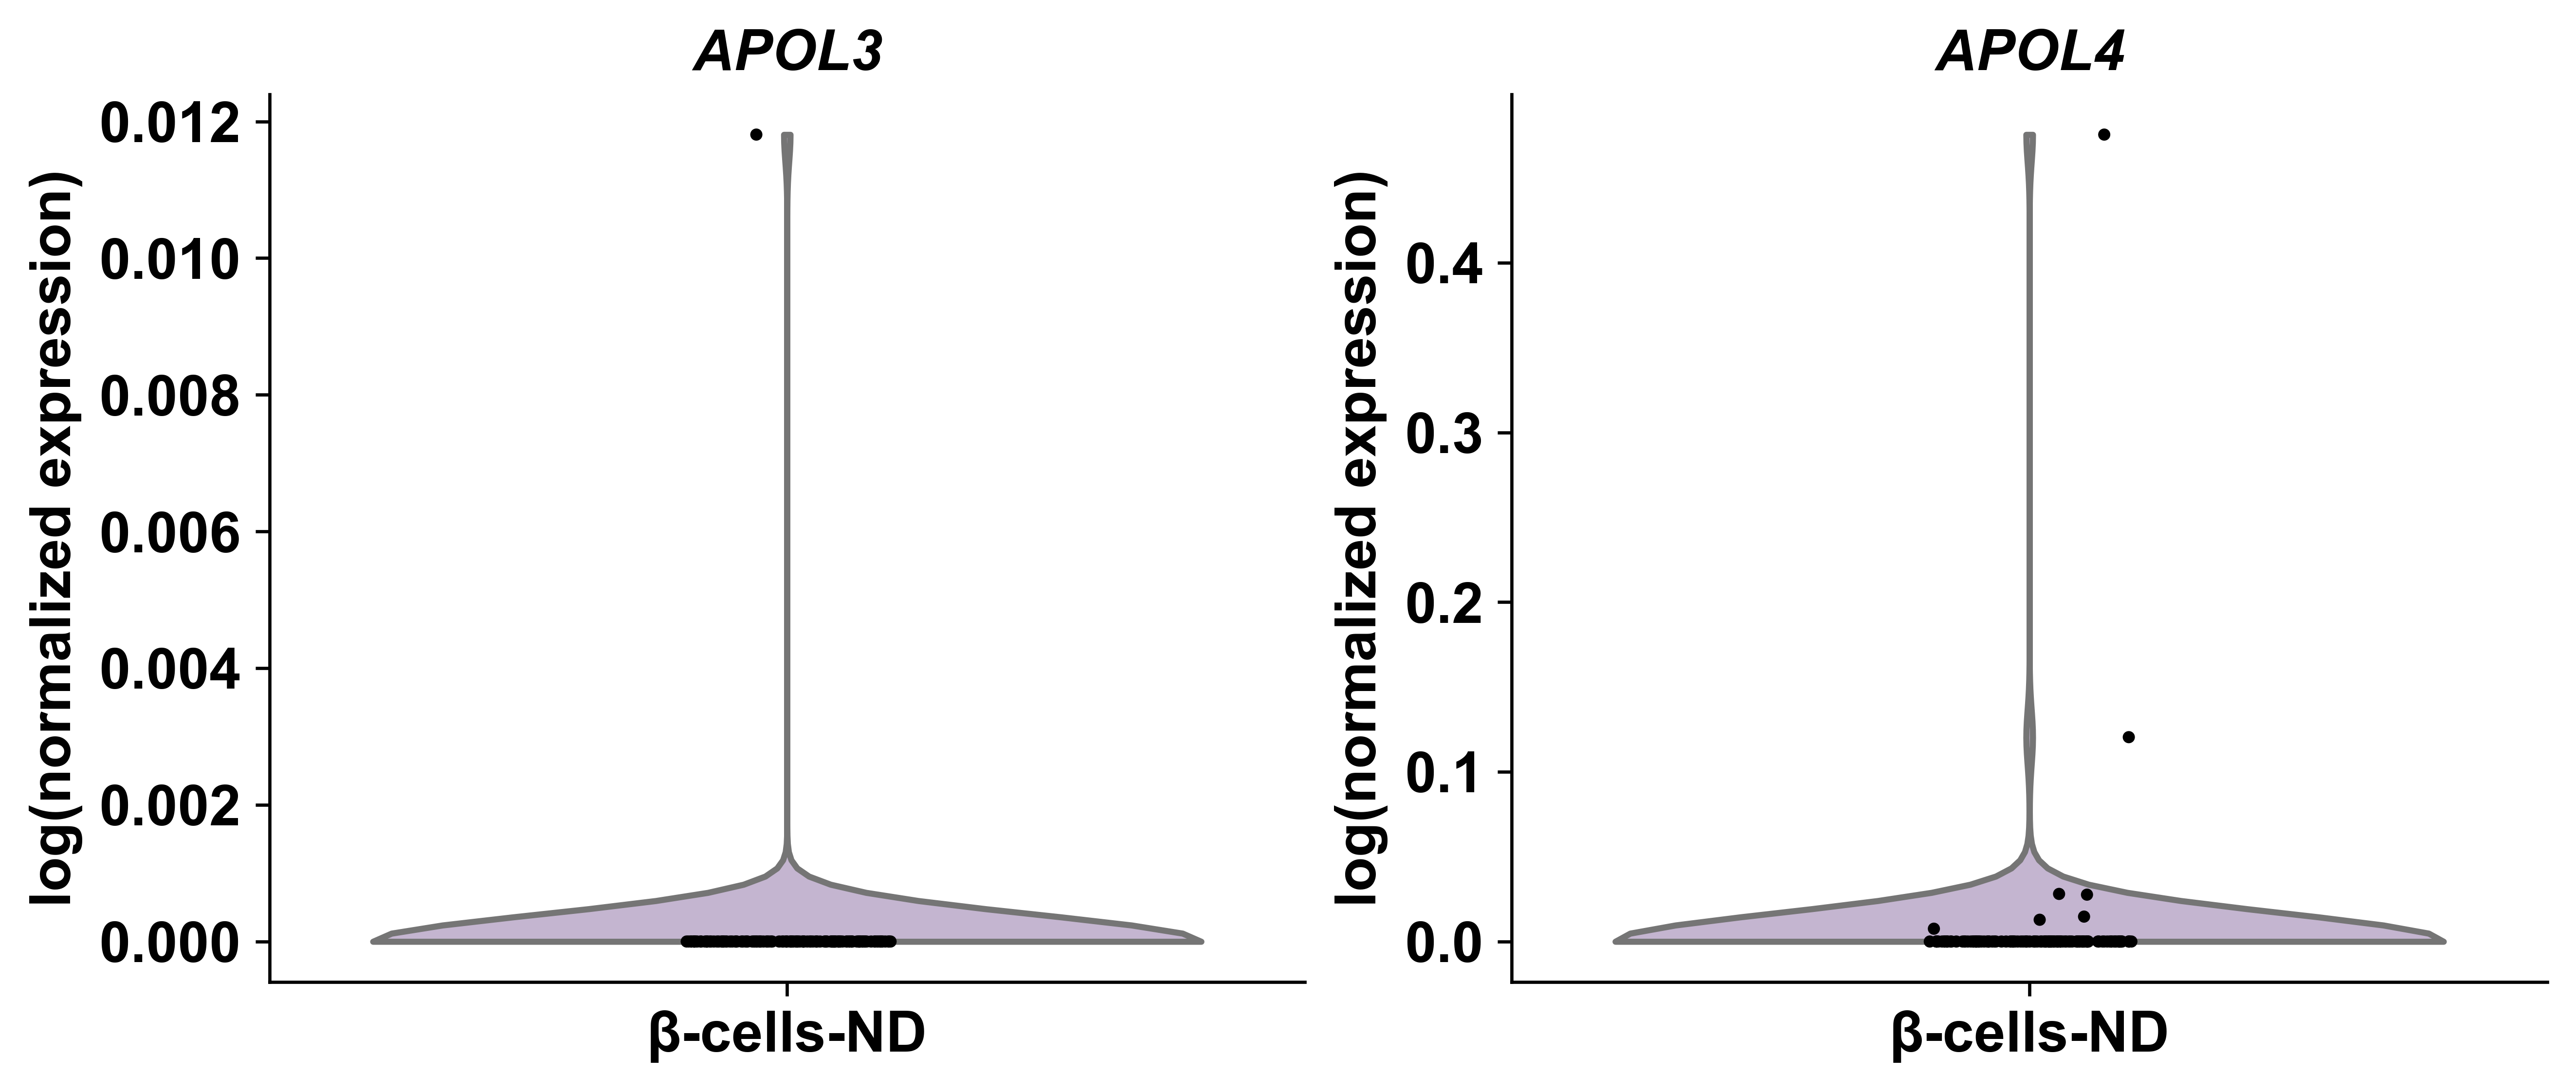

In [217]:
genes = ['APOL3', 'APOL4']
group = 'cluster-group'
order = ['β-cells-ND']

violin(adata, genes, groupby=group,  order=order, savefile=str(figdir+ '/' + 'violin_APOL34_betaND'))

STAT2, IRF9, IFI6 expression in ND and T2D beta cells

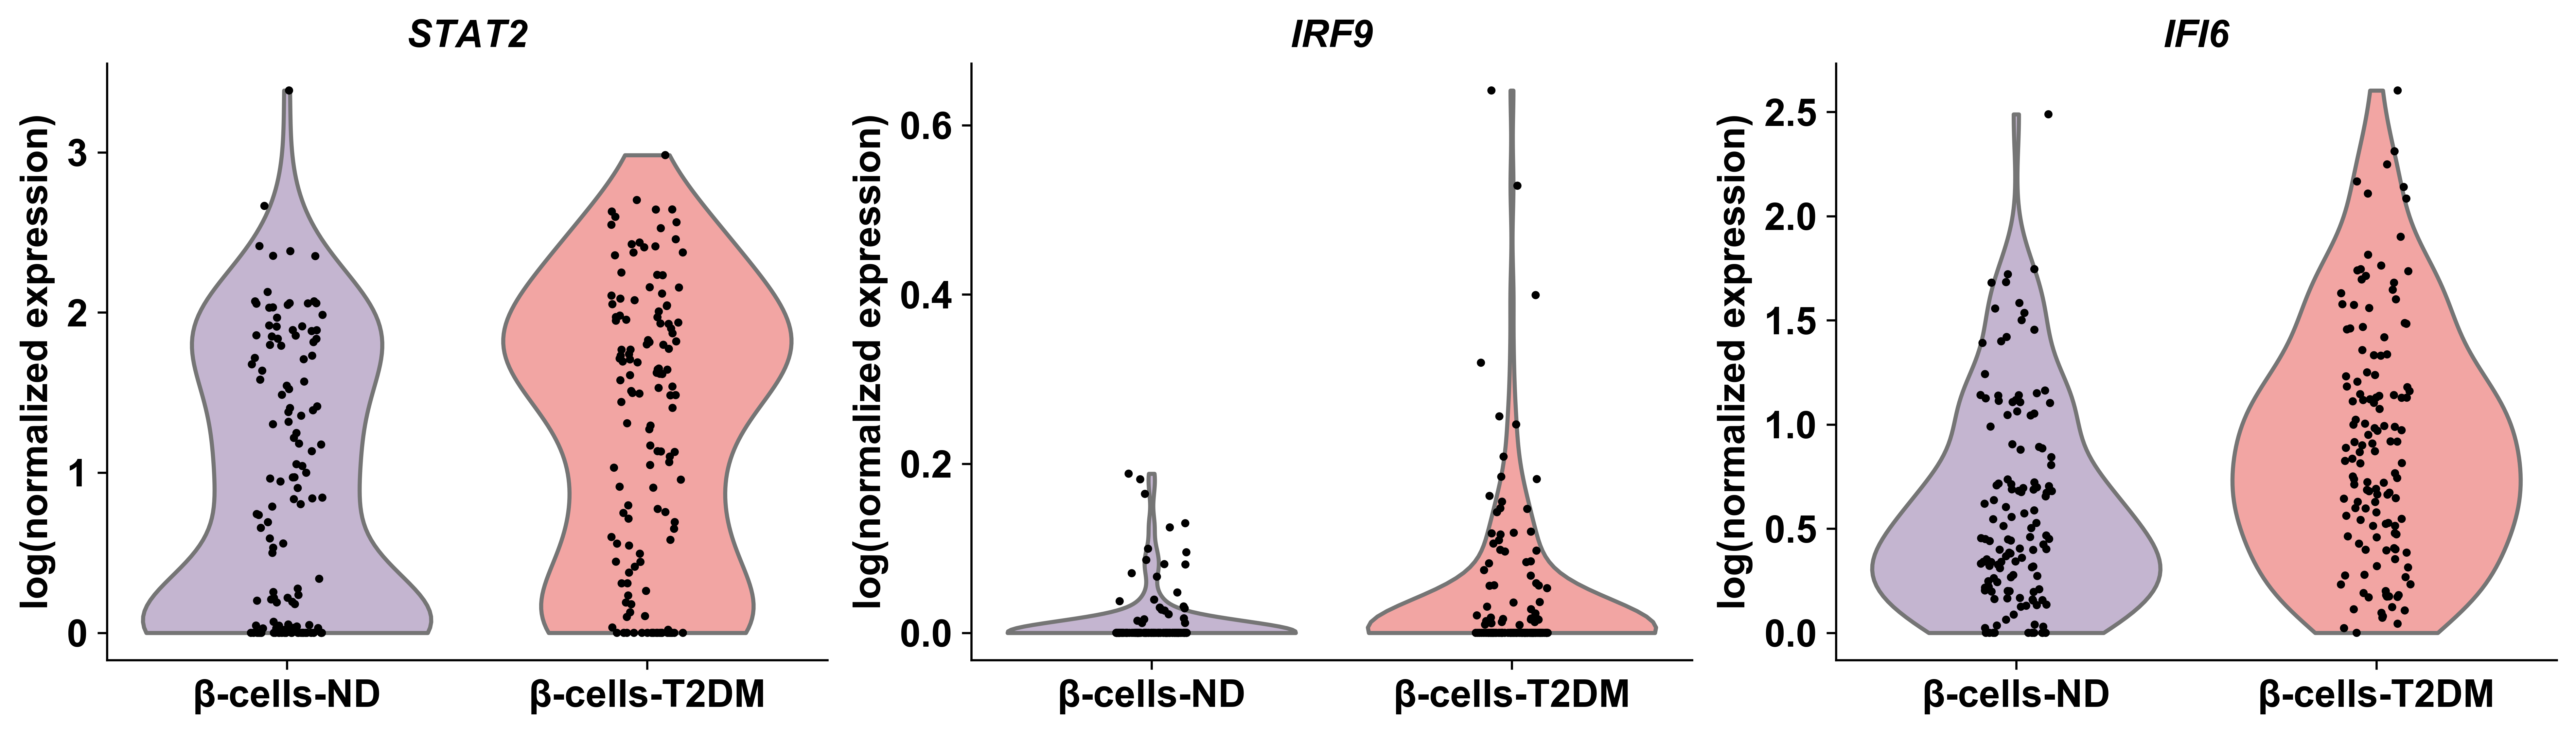

In [218]:
genes = ['STAT2', 'IRF9', 'IFI6']
group = 'cluster-group'
order = ['β-cells-ND', 'β-cells-T2DM']

violin(adata, genes, groupby=group,  order=order, savefile=str(figdir+ '/violin_STAT2-IRF9-IFI6_betaND-T2D'))

## Volcano plots
Volcano plots for APOL1, APOL2, APOL6 in beta cells T2DM vs ND 

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


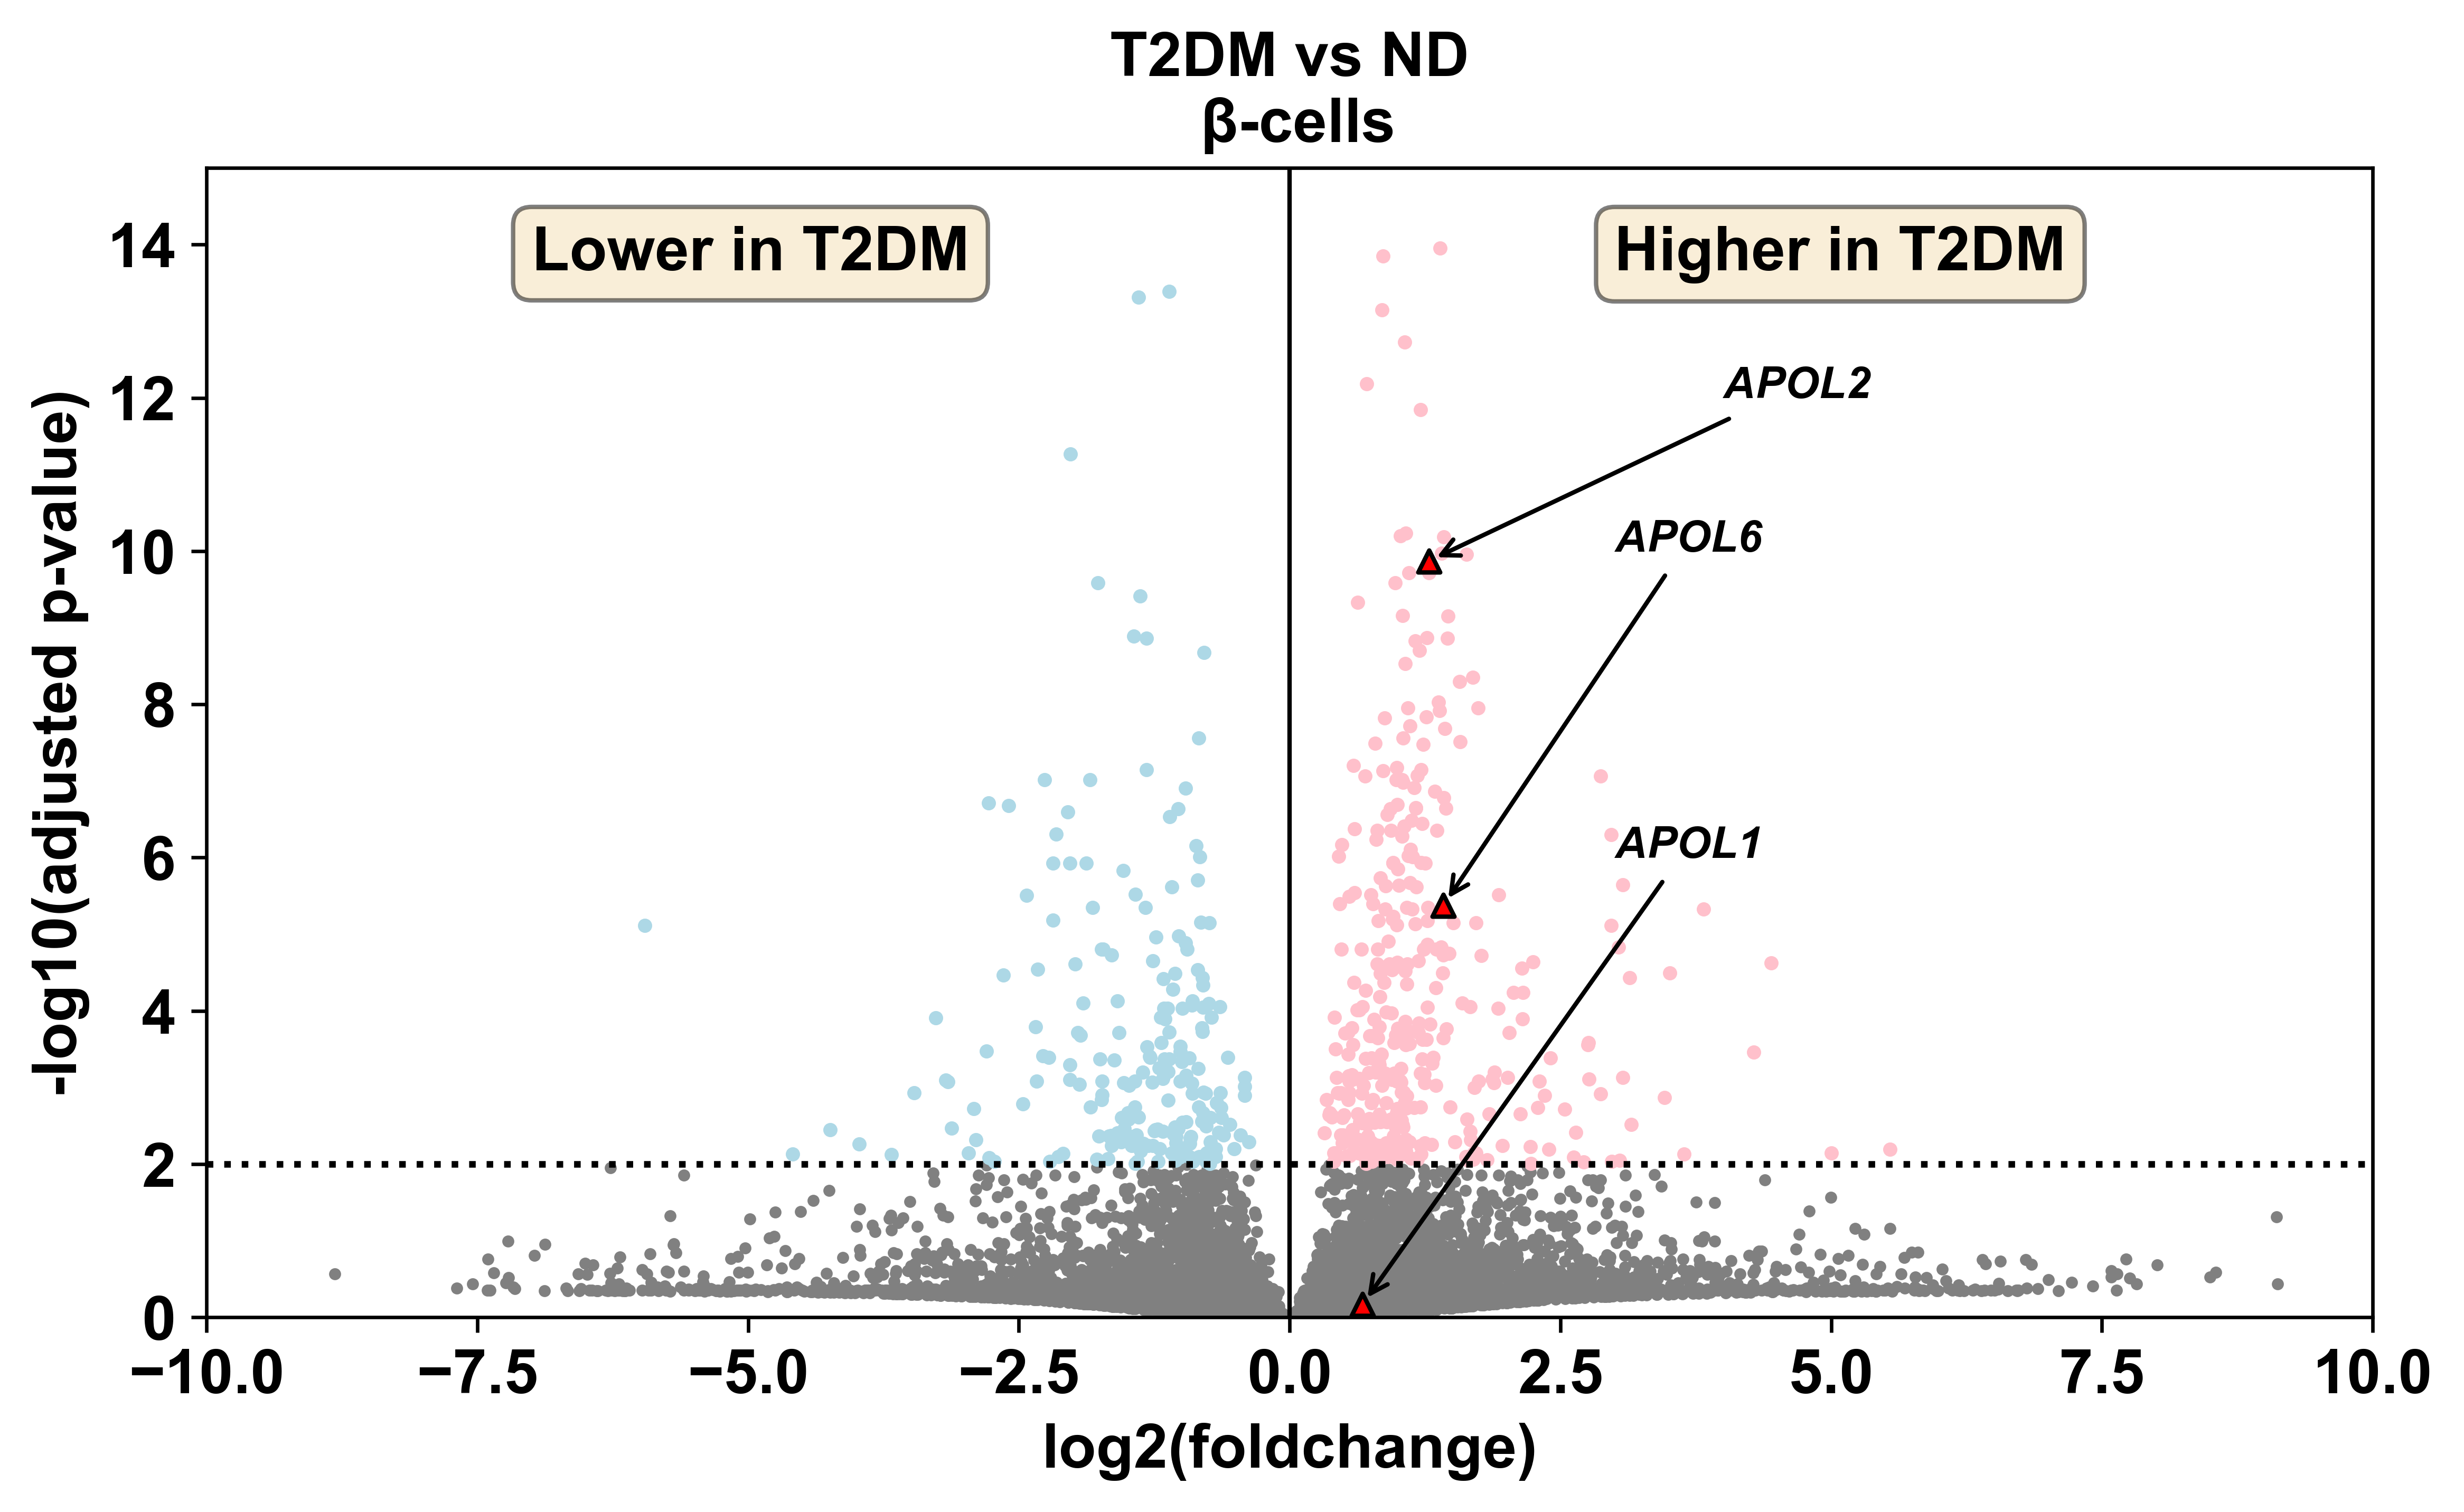

In [212]:
adata_n = adata_dict['β-cells']

sc.tl.rank_genes_groups(adata_n, 'Group', method='t-test')

result = adata_n.uns['rank_genes_groups']

group = 'T2DM'

df = pd.DataFrame({'logfoldchanges': result['logfoldchanges'][group],
              'pvals_adj': -np.log(result['pvals_adj'][group])}, index=result['names'][group])

unsig = df[(df['pvals_adj'] < 2)]
sig_up = df[(df['pvals_adj'] > 2) & ((df['logfoldchanges'] > 0))]
sig_down = df[(df['pvals_adj'] > 2) & ((df['logfoldchanges'] < 0))]

x_unsig = unsig['logfoldchanges']
y_unsig = unsig['pvals_adj']

x_sig_up = sig_up['logfoldchanges']
y_sig_up = sig_up['pvals_adj']

x_sig_down = sig_down['logfoldchanges']
y_sig_down = sig_down['pvals_adj']

fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.scatter(x_unsig,y_unsig, s=3, c='gray')
ax.scatter(x_sig_up,y_sig_up, s=5, c='pink')
ax.scatter(x_sig_down,y_sig_down, s=5, c='lightblue')
sigfold_high = df[(df['pvals_adj'] > 4) & ((df['logfoldchanges'] > 2) | (df['logfoldchanges'] < -2))]

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Sans:italic:bold'
genes = ['APOL1', 'APOL2','APOL6']# 'APOL3', 'APOL4']
xytext = {'APOL1':[3,6], 'APOL2':[4,12], 'APOL3':[7.5,3],'APOL4':[5,6], 'APOL5':[-7,6], 'APOL6':[3,10]}
for gene in genes:
    x = df.loc[gene,'logfoldchanges']
    y = df.loc[gene,'pvals_adj']
    ax.scatter(x,y, s=25, c='red', edgecolors='black', marker="^")
    xtext = xytext[gene][0]
    ytext = xytext[gene][1]
    plt.annotate(r"$\mathbf{"+gene+"}$", xy=(x,y), xytext=(xtext, ytext), arrowprops=dict(arrowstyle="->",
                connectionstyle="arc3"), size=10)
    
ax.set_xlabel('log2(foldchange)')
ax.set_ylabel('-log10(adjusted p-value)')
ax.set_xlim(-10,10)
ax.set_ylim(0,15)

ax.set_title('T2DM vs ND\n β-cells', fontweight="bold")
ax.axvline(0, color='black', linewidth=1)
#ax.axvline(2, ls=":", color='black')
ax.axhline(2, ls=":", color='black')

textlow = str('Lower in T2DM')
texthigh = str('Higher in T2DM')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.15, 0.95, textlow, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax.text(0.65, 0.95, texthigh, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

plt.grid(None)

fig.tight_layout()
fig.savefig(str(figdir+'/volcano_betacells_AllAPOL.png'))

Volcano plots for APOL1, APOL2, APOL3, APOL4, APOL6 in all cells T2DM vs ND 

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


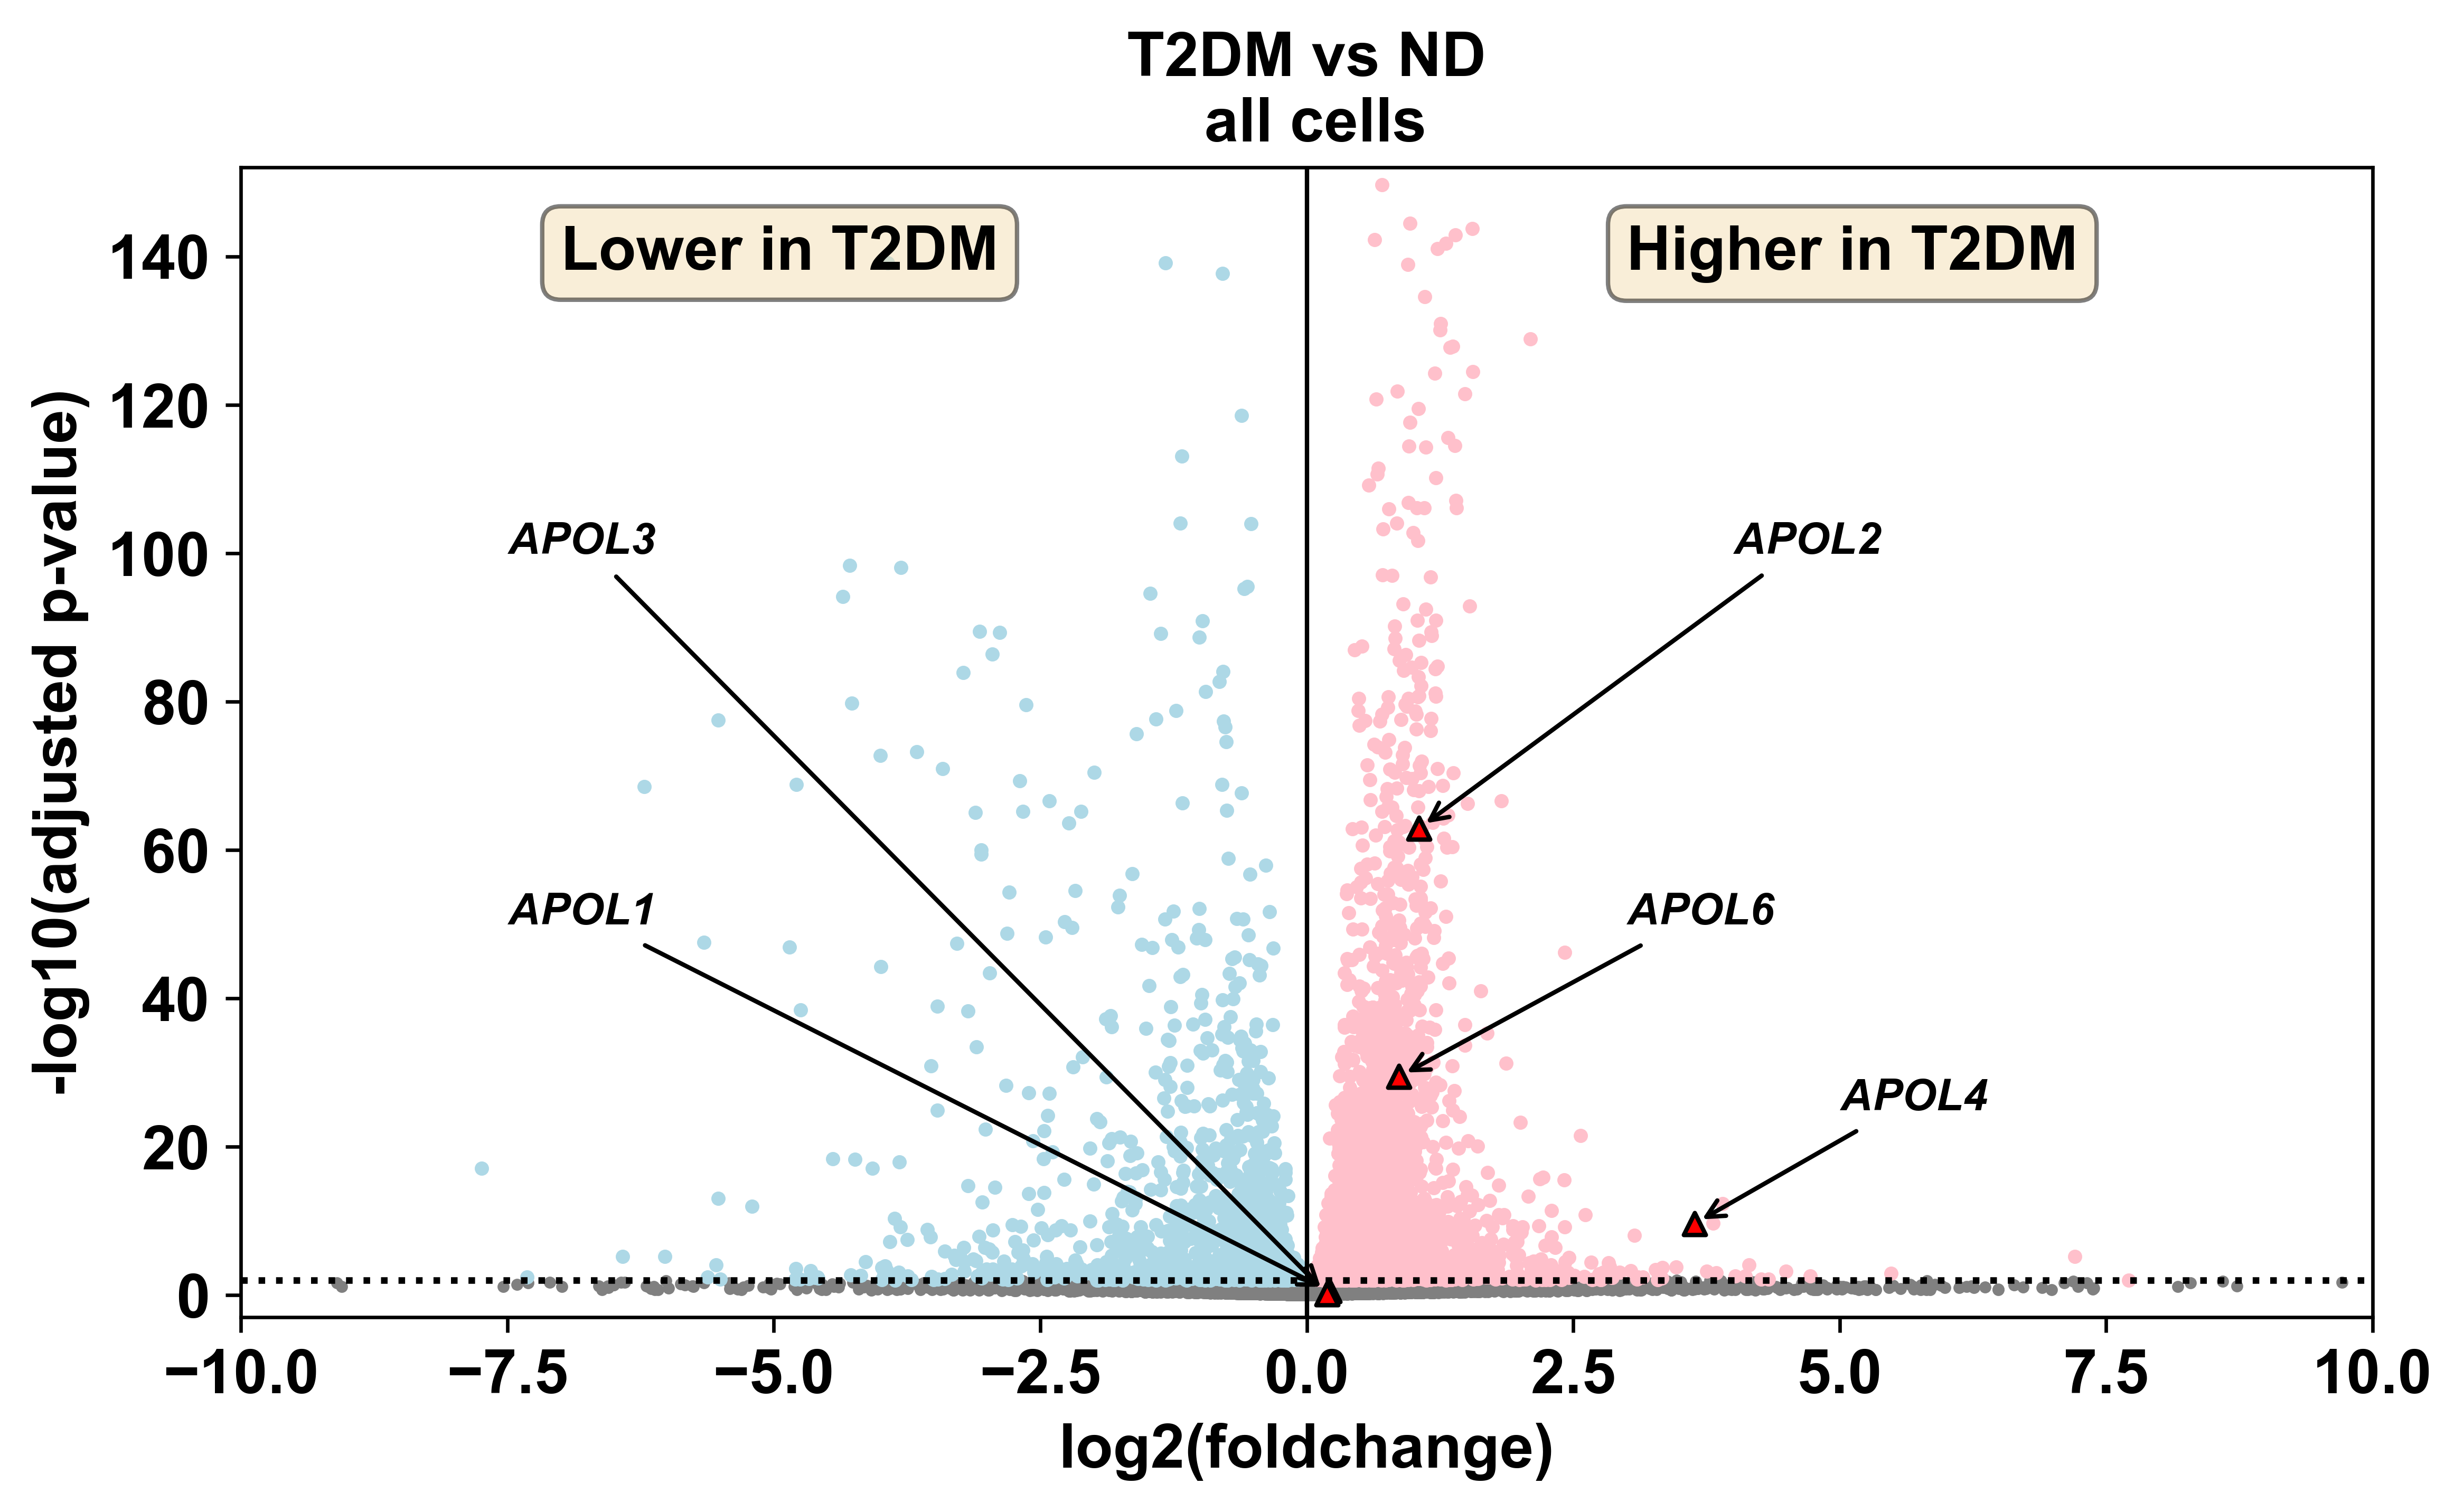

In [211]:
adata_n = adata

sc.tl.rank_genes_groups(adata_n, 'Group', method='t-test')

result = adata_n.uns['rank_genes_groups']

group = 'T2DM'

df = pd.DataFrame({'logfoldchanges': result['logfoldchanges'][group],
              'pvals_adj': -np.log(result['pvals_adj'][group])}, index=result['names'][group])

unsig = df[(df['pvals_adj'] < 2)]
sig_up = df[(df['pvals_adj'] > 2) & ((df['logfoldchanges'] > 0))]
sig_down = df[(df['pvals_adj'] > 2) & ((df['logfoldchanges'] < 0))]

x_unsig = unsig['logfoldchanges']
y_unsig = unsig['pvals_adj']

x_sig_up = sig_up['logfoldchanges']
y_sig_up = sig_up['pvals_adj']

x_sig_down = sig_down['logfoldchanges']
y_sig_down = sig_down['pvals_adj']

fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.scatter(x_unsig,y_unsig, s=3, c='gray')
ax.scatter(x_sig_up,y_sig_up, s=5, c='pink')
ax.scatter(x_sig_down,y_sig_down, s=5, c='lightblue')
sigfold_high = df[(df['pvals_adj'] > 4) & ((df['logfoldchanges'] > 2) | (df['logfoldchanges'] < -2))]

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'Sans:italic:bold'
genes = ['APOL1', 'APOL2','APOL6','APOL3', 'APOL4']
xytext = {'APOL1':[-7.5,50], 'APOL2':[4,100], 'APOL3':[-7.5,100],'APOL4':[5,25], 'APOL5':[-20,30], 'APOL6':[3,50]}
for gene in genes:
    x = df.loc[gene,'logfoldchanges']
    y = df.loc[gene,'pvals_adj']
    ax.scatter(x,y, s=25, c='red', edgecolors='black', marker="^")
    xtext = xytext[gene][0]
    ytext = xytext[gene][1]
    plt.annotate(r"$\mathbf{"+gene+"}$", xy=(x,y), xytext=(xtext, ytext), arrowprops=dict(arrowstyle="->",
                connectionstyle="arc3"), size=10)
    
ax.set_xlabel('log2(foldchange)')
ax.set_ylabel('-log10(adjusted p-value)')
ax.set_xlim(-10,10)
ax.set_ylim(-3,152)

ax.set_title('T2DM vs ND\n all cells', fontweight="bold")
ax.axvline(0, color='black', linewidth=1)
ax.axhline(2, ls=":", color='black')

textlow = str('Lower in T2DM')
texthigh = str('Higher in T2DM')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.15, 0.95, textlow, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax.text(0.65, 0.95, texthigh, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

plt.grid(None)

fig.tight_layout()
fig.savefig(str(figdir+'/volcano_Allcells_AllAPOL.png'))

## Enricher term analysis plot
Reactome term analysis on upregulated T2D genes. Because the dataset contains a high number of ribosomal genes which interferes with the term analysis we removed them from the dataset. 

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


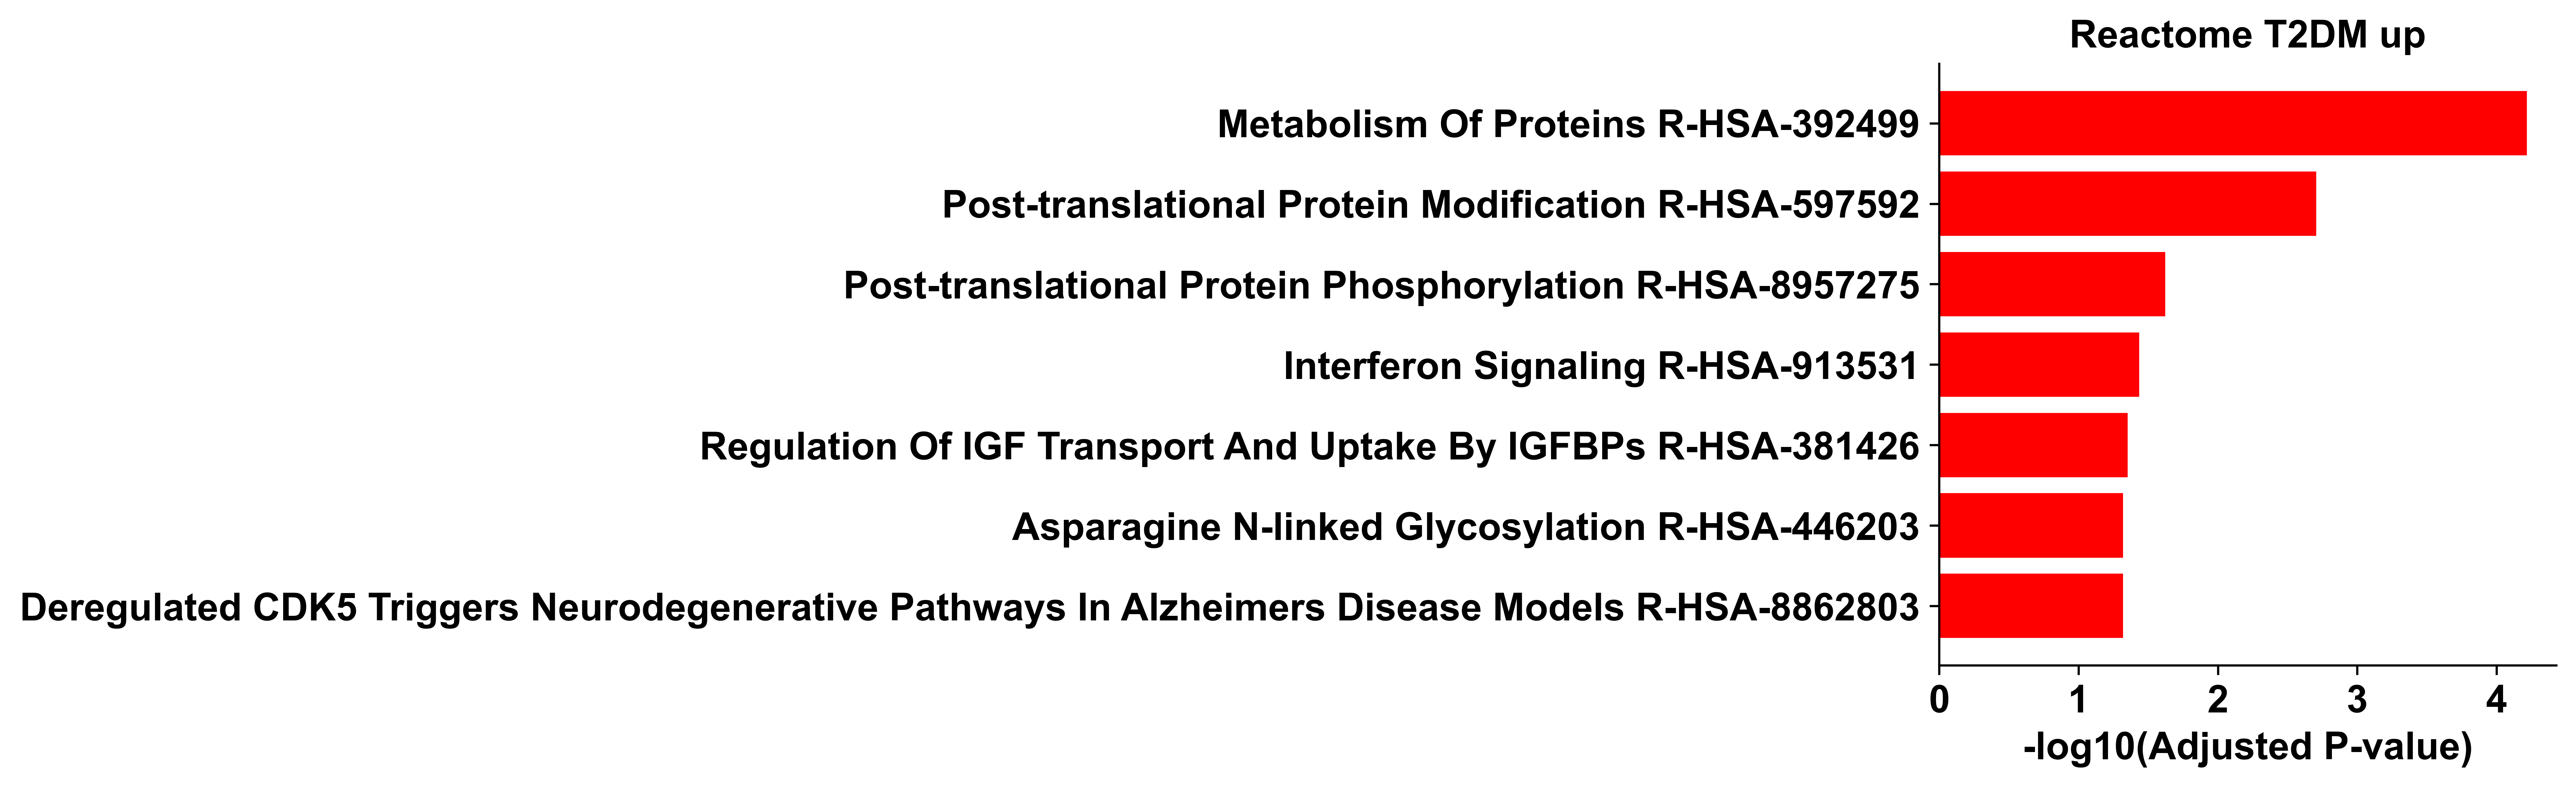

In [227]:
enricher_df = pd.DataFrame()

adata_n = adata_dict['β-cells']

sc.tl.rank_genes_groups(adata_n, 'Group', method='t-test')

result = adata_n.uns['rank_genes_groups']

group = 'T2DM'

df = pd.DataFrame({'logfoldchanges': result['logfoldchanges'][group],
              'pvals_adj': -np.log(result['pvals_adj'][group])}, index=result['names'][group])

sig_up = df[(df['pvals_adj'] > 2) & ((df['logfoldchanges'] > 0))]

# remove ribosomal gene family RPS and RPL
sig_genes_up = list(sig_up.index)
sig_genes_minusRP = []
for gene in sig_genes_up:
    if gene.startswith('RPL') == False and gene.startswith('RPS') == False: 
        sig_genes_minusRP.append(gene)

background_genes = list(adata.raw.var.index)
background_genes_minusRP = []
for gene in background_genes:
    if gene.startswith('RPL') == False and gene.startswith('RPS') == False:
        background_genes_minusRP.append(gene)

enr_up = gseapy.enrichr(gene_list=sig_genes_minusRP,
                     organism='Human',
                     background=background_genes_minusRP ,
                     gene_sets='Reactome_2022',
                     description='pathway',
                     cutoff = 0.1)
enr_up_df = enr_up.results

enr_up_df.to_csv('enr_Reactome_2022_up.csv')

fig, ax = plt.subplots(figsize=(4,4))

df_sig = enr_up_df[enr_up_df['Adjusted P-value']< 0.05]
data = list(-np.log10(df_sig['Adjusted P-value']))
labels = list(df_sig['Term'])

data.reverse()
labels.reverse()

ax.barh(range(len(df_sig.index)), data, align='center', color='red')
ax.set_yticks(range(len(df_sig.index)))
ax.set_yticklabels(labels)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('-log10(Adjusted P-value)')

ax.set_title('Reactome T2DM up', fontweight="bold");


## Differential gene expression analysis
Differential gene expression and t-test statistics for APOL1, APOL2, APOL3, APOL4, APOL6, ATF3, STAT2,IRF9, and IFI6 for each cell type separetly and all cells in the dataset 

In [ ]:
sc.settings.verbosity = 0

In [244]:
gene = 'APOL1'
test='t-test'

dfx = pd.DataFrame()
for ct in adata_dict:
    sc.tl.rank_genes_groups(adata_dict[ct], 'Group', method=test)
    result = adata_dict[ct].uns['rank_genes_groups']
    group = 'T2DM'
    df = pd.DataFrame({str('logfoldchanges '+gene): result['logfoldchanges'][group],
              str('pvals_adj '+test+' '+gene): result['pvals_adj'][group]}, index=result['names'][group])
    dfx_ct = pd.DataFrame(df.loc[gene]).T
    dfx_ct = dfx_ct.rename(index={gene: str(group+'_'+ct)})
    dfx = dfx.append(dfx_ct)
dfx

/Users/twanw/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cluster-group' as categorical
/Users/twanw/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cluster-group' as categorical
/Users/twanw/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cluster-group' as categorical
/Users/twanw/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cluster-group' as categorical
/Use

logfoldchanges APOL1  pvals_adj t-test APOL1
T2DM_β-cells                        0.670777                0.848454
T2DM_Acinar cells                   0.651790                0.531249
T2DM_α-cells                        1.334524                0.267308
T2DM_Ductal cells                   0.962693                0.141601
T2DM_PP-cells                       0.171394                1.000000
T2DM_Stellate cells                -1.036587                0.483673
T2DM_δ-cells                       -0.057695                1.000000
T2DM_Endothelial cells             -0.640510                1.000000
T2DM_all_cells                      0.207902                0.554603

In [245]:
gene = 'APOL2'
test='t-test'

dfx = pd.DataFrame()
for ct in adata_dict:
    sc.tl.rank_genes_groups(adata_dict[ct], 'Group', method=test)
    result = adata_dict[ct].uns['rank_genes_groups']
    group = 'T2DM'
    df = pd.DataFrame({str('logfoldchanges '+gene): result['logfoldchanges'][group],
              str('pvals_adj '+test+' '+gene): result['pvals_adj'][group]}, index=result['names'][group])
    dfx_ct = pd.DataFrame(df.loc[gene]).T
    dfx_ct = dfx_ct.rename(index={gene: str(group+'_'+ct)})
    dfx = dfx.append(dfx_ct)
dfx

logfoldchanges APOL2  pvals_adj t-test APOL2
T2DM_β-cells                        1.284163            5.166418e-05
T2DM_Acinar cells                   2.247563            5.837730e-05
T2DM_α-cells                        0.931652            1.139194e-11
T2DM_Ductal cells                   0.789917            6.829848e-03
T2DM_PP-cells                       0.234330            9.392926e-01
T2DM_Stellate cells                 1.341731            1.087298e-01
T2DM_δ-cells                        0.136224            1.000000e+00
T2DM_Endothelial cells              0.854105            9.226687e-01
T2DM_all_cells                      1.053043            4.840335e-28

In [246]:
gene = 'APOL3'
test='t-test'

dfx = pd.DataFrame()
for ct in adata_dict:
    sc.tl.rank_genes_groups(adata_dict[ct], 'Group', method=test)
    result = adata_dict[ct].uns['rank_genes_groups']
    group = 'T2DM'
    df = pd.DataFrame({str('logfoldchanges '+gene): result['logfoldchanges'][group],
              str('pvals_adj '+test+' '+gene): result['pvals_adj'][group]}, index=result['names'][group])
    dfx_ct = pd.DataFrame(df.loc[gene]).T
    dfx_ct = dfx_ct.rename(index={gene: str(group+'_'+ct)})
    dfx = dfx.append(dfx_ct)
dfx

logfoldchanges APOL3  pvals_adj t-test APOL3
T2DM_β-cells                        6.729866                0.703411
T2DM_Acinar cells                 -18.308868                0.531249
T2DM_α-cells                        3.253893                0.467033
T2DM_Ductal cells                   1.125118                0.736779
T2DM_PP-cells                       4.949886                0.820865
T2DM_Stellate cells                -0.623611                0.788246
T2DM_δ-cells                        1.454179                0.959956
T2DM_Endothelial cells             -0.575401                1.000000
T2DM_all_cells                      0.189470                0.834690

In [248]:
gene = 'APOL4'
test='t-test'

dfx = pd.DataFrame()
for ct in adata_dict:
    sc.tl.rank_genes_groups(adata_dict[ct], 'Group', method=test)
    result = adata_dict[ct].uns['rank_genes_groups']
    group = 'T2DM'
    df = pd.DataFrame({str('logfoldchanges '+gene): result['logfoldchanges'][group],
              str('pvals_adj '+test+' '+gene): result['pvals_adj'][group]}, index=result['names'][group])
    dfx_ct = pd.DataFrame(df.loc[gene]).T
    dfx_ct = dfx_ct.rename(index={gene: str(group+'_'+ct)})
    dfx = dfx.append(dfx_ct)
dfx

logfoldchanges APOL4  pvals_adj t-test APOL4
T2DM_β-cells                        4.285161                0.031373
T2DM_Acinar cells                  24.204472                0.531249
T2DM_α-cells                        2.696655                0.451482
T2DM_Ductal cells                   1.422865                0.623719
T2DM_PP-cells                      21.950972                0.814255
T2DM_Stellate cells                25.748482                0.591915
T2DM_δ-cells                        0.077386                1.000000
T2DM_Endothelial cells              5.081818                0.922669
T2DM_all_cells                      3.637711                0.000066

In [249]:
gene = 'APOL6'
test='t-test'

dfx = pd.DataFrame()
for ct in adata_dict:
    sc.tl.rank_genes_groups(adata_dict[ct], 'Group', method=test)
    result = adata_dict[ct].uns['rank_genes_groups']
    group = 'T2DM'
    df = pd.DataFrame({str('logfoldchanges '+gene): result['logfoldchanges'][group],
              str('pvals_adj '+test+' '+gene): result['pvals_adj'][group]}, index=result['names'][group])
    dfx_ct = pd.DataFrame(df.loc[gene]).T
    dfx_ct = dfx_ct.rename(index={gene: str(group+'_'+ct)})
    dfx = dfx.append(dfx_ct)
dfx

logfoldchanges APOL6  pvals_adj t-test APOL6
T2DM_β-cells                        1.418926            4.634303e-03
T2DM_Acinar cells                   1.444504            2.051995e-02
T2DM_α-cells                        0.565075            2.564160e-03
T2DM_Ductal cells                   0.887351            1.053987e-02
T2DM_PP-cells                       1.306102            4.841135e-01
T2DM_Stellate cells                 0.470625            7.716199e-01
T2DM_δ-cells                        0.340395            1.000000e+00
T2DM_Endothelial cells              1.300763            9.226687e-01
T2DM_all_cells                      0.865665            1.638754e-13

In [250]:
gene = 'ATF3'
test='t-test'

dfx = pd.DataFrame()
for ct in adata_dict:
    sc.tl.rank_genes_groups(adata_dict[ct], 'Group', method=test)
    result = adata_dict[ct].uns['rank_genes_groups']
    group = 'T2DM'
    df = pd.DataFrame({str('logfoldchanges '+gene): result['logfoldchanges'][group],
              str('pvals_adj '+test+' '+gene): result['pvals_adj'][group]}, index=result['names'][group])
    dfx_ct = pd.DataFrame(df.loc[gene]).T
    dfx_ct = dfx_ct.rename(index={gene: str(group+'_'+ct)})
    dfx = dfx.append(dfx_ct)
dfx

logfoldchanges ATF3  pvals_adj t-test ATF3
T2DM_β-cells                      -0.518355           7.034106e-01
T2DM_Acinar cells                 -1.326717           1.290007e-03
T2DM_α-cells                      -1.030166           2.390296e-07
T2DM_Ductal cells                 -1.452549           1.148771e-05
T2DM_PP-cells                     -0.186773           1.000000e+00
T2DM_Stellate cells               -0.768775           7.510668e-01
T2DM_δ-cells                       0.725315           9.521365e-01
T2DM_Endothelial cells           -26.534634           9.226687e-01
T2DM_all_cells                    -1.253794           3.409070e-23

In [251]:
gene = 'STAT2'
test='t-test'

dfx = pd.DataFrame()
for ct in adata_dict:
    sc.tl.rank_genes_groups(adata_dict[ct], 'Group', method=test)
    result = adata_dict[ct].uns['rank_genes_groups']
    group = 'T2DM'
    df = pd.DataFrame({str('logfoldchanges '+gene): result['logfoldchanges'][group],
              str('pvals_adj '+test+' '+gene): result['pvals_adj'][group]}, index=result['names'][group])
    dfx_ct = pd.DataFrame(df.loc[gene]).T
    dfx_ct = dfx_ct.rename(index={gene: str(group+'_'+ct)})
    dfx = dfx.append(dfx_ct)
dfx

logfoldchanges STAT2  pvals_adj t-test STAT2
T2DM_β-cells                        0.794490            4.082380e-02
T2DM_Acinar cells                   1.247214            4.672831e-03
T2DM_α-cells                        1.241981            6.194606e-29
T2DM_Ductal cells                   0.889800            1.336161e-03
T2DM_PP-cells                       0.813828            6.507044e-01
T2DM_Stellate cells                 0.726862            3.471188e-01
T2DM_δ-cells                        0.218376            1.000000e+00
T2DM_Endothelial cells              1.812804            9.226687e-01
T2DM_all_cells                      1.209132            1.399053e-48

In [252]:
gene = 'IRF9'
test='t-test'

dfx = pd.DataFrame()
for ct in adata_dict:
    sc.tl.rank_genes_groups(adata_dict[ct], 'Group', method=test)
    result = adata_dict[ct].uns['rank_genes_groups']
    group = 'T2DM'
    df = pd.DataFrame({str('logfoldchanges '+gene): result['logfoldchanges'][group],
              str('pvals_adj '+test+' '+gene): result['pvals_adj'][group]}, index=result['names'][group])
    dfx_ct = pd.DataFrame(df.loc[gene]).T
    dfx_ct = dfx_ct.rename(index={gene: str(group+'_'+ct)})
    dfx = dfx.append(dfx_ct)
dfx

logfoldchanges IRF9  pvals_adj t-test IRF9
T2DM_β-cells                       1.706008           4.992862e-02
T2DM_Acinar cells                  1.578508           1.000283e-02
T2DM_α-cells                       0.551039           2.021121e-03
T2DM_Ductal cells                  0.785687           6.048811e-02
T2DM_PP-cells                      1.294954           7.689994e-01
T2DM_Stellate cells               -0.305299           9.124934e-01
T2DM_δ-cells                       0.386485           1.000000e+00
T2DM_Endothelial cells             0.815051           1.000000e+00
T2DM_all_cells                     0.703384           3.623995e-08

In [253]:
gene = 'IFI6'
test='t-test'

dfx = pd.DataFrame()
for ct in adata_dict:
    sc.tl.rank_genes_groups(adata_dict[ct], 'Group', method=test)
    result = adata_dict[ct].uns['rank_genes_groups']
    group = 'T2DM'
    df = pd.DataFrame({str('logfoldchanges '+gene): result['logfoldchanges'][group],
              str('pvals_adj '+test+' '+gene): result['pvals_adj'][group]}, index=result['names'][group])
    dfx_ct = pd.DataFrame(df.loc[gene]).T
    dfx_ct = dfx_ct.rename(index={gene: str(group+'_'+ct)})
    dfx = dfx.append(dfx_ct)
dfx

logfoldchanges IFI6  pvals_adj t-test IFI6
T2DM_β-cells                       0.864172           7.995282e-04
T2DM_Acinar cells                  1.742625           5.549688e-03
T2DM_α-cells                       0.623362           4.602941e-19
T2DM_Ductal cells                  0.994174           4.493200e-04
T2DM_PP-cells                     -0.385728           8.142554e-01
T2DM_Stellate cells                0.083343           1.000000e+00
T2DM_δ-cells                      -0.612640           9.068477e-01
T2DM_Endothelial cells            -0.094149           1.000000e+00
T2DM_all_cells                     0.758005           4.014732e-35